## Natural Language Processing (NLP) | Turkish News Categorization Using Feedforward Neural Networks

##### Esra Sekerci - 2698215
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import nltk
import ssl
from nltk import word_tokenize,sent_tokenize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from snowballstemmer import TurkishStemmer
from zeyrek import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import string
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from collections import defaultdict
from nltk.tokenize import word_tokenize

In [2]:
data_dir = r"/Users/esrasekerci/Desktop/42bin_haber/news"

def read_text(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()
    return text

dataset_rows = []

for subdir, _, files in os.walk(data_dir):
    folder_name = os.path.basename(subdir)
    for file in files:
        file_path = os.path.join(subdir, file)
        text = read_text(file_path)
        dataset_rows.append((text, folder_name))

df = pd.DataFrame(dataset_rows, columns=['text', 'category'])
df = df[df['category'] != 'news']
df.head()

,text,category
1,"""Özel sektör yapmazsa biz yaparız""\nEkonomi Ba...",ekonomi
2,Turizimde gelir artışı\n \n Türkiye’nin 2012 y...,ekonomi
3,Apple'ın yerini Google alabilir\nSon yıllarda ...,ekonomi
4,"ING, 2 bin 400 kişiyi işten çıkaracak\nHolland...",ekonomi
5,Okmeydanı Hastanesi için geri sayım başladı\nİ...,ekonomi


In [3]:
# Filter out 'teknoloji' and 'yasam' categories
df = df[~df['category'].isin(['teknoloji', 'yasam','siyaset', 'guncel', 'planet', 'magazin', 'turkiye', 'genel'])]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19524 entries, 1 to 40053
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      19524 non-null  object
 1   category  19524 non-null  object
dtypes: object(2)
memory usage: 457.6+ KB


In [5]:
df['category'].value_counts()

category
spor            9997
dunya           3724
ekonomi         3265
saglik          1383
kultur-sanat    1155
Name: count, dtype: int64

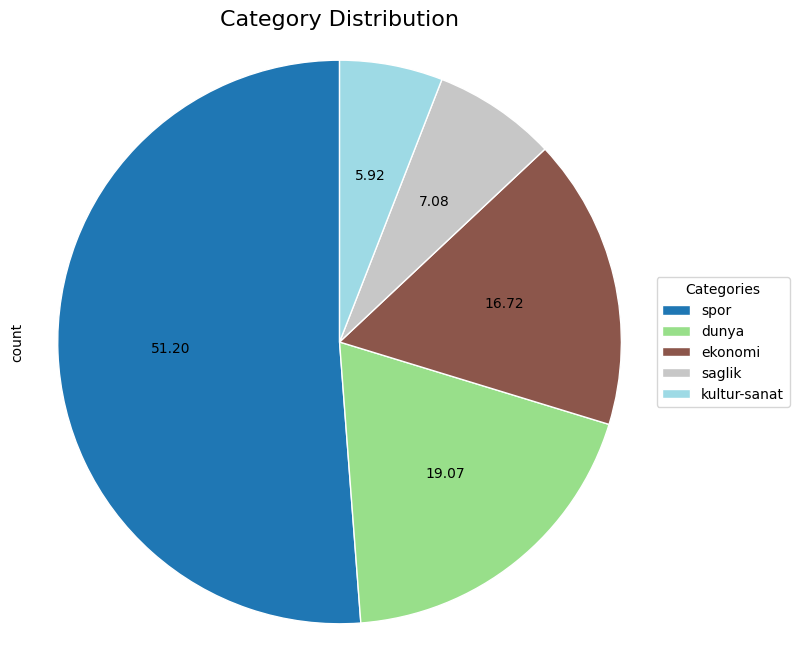

In [6]:
# Generate a color map with unique colors for each category
unique_categories = df['category'].nunique()
cmap = plt.get_cmap('tab20', unique_categories)  # Using 'tab20' for up to 20 distinct colors

# Create the pie chart
fig, ax = plt.subplots(figsize=(6,6))  # Adjusted figure size for better readability
df['category'].value_counts().plot.pie(
    autopct='%1.2f', 
    startangle=90,      # Start angle for better visual balance
    colors=[cmap(i) for i in range(unique_categories)],  # Apply custom color palette
    wedgeprops={'edgecolor': 'white'},  # Edge color for better separation between slices
    labels=None  # Do not add category names on the pie chart
)

# Add a title
ax.set_title('Category Distribution', fontsize=16)

# Add a legend
ax.legend(
    df['category'].value_counts().index, 
    title="Categories", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5)
)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Display the plot
plt.show()


In [6]:
# Sample a smaller subset while maintaining label distribution
# df = df.groupby('category').apply(lambda x: x.sample(n=min(1000, len(x)), random_state=42)).reset_index(drop=True)

/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_11815/1656086650.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('category').apply(lambda x: x.sample(n=min(1000, len(x)), random_state=42)).reset_index(drop=True)


##### Data Preprocessing and Representation

In [7]:
df_1 = df.copy()

In [8]:
# Cleaning stopwords
def clean_stopwords(content):
    # Get NLTK Turkish stopwords
    nltk_stopwords = set(stopwords.words("turkish"))
    
    # Split content into words, filter out stopwords, and join back into a string
    return ' '.join(word for word in content.split() if word not in nltk_stopwords)


#  cleaning URLs
def clean_url(content):
    #  content: str
    #  return: str
    reg_url = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    pattern_url = re.compile(reg_url)
    content = pattern_url.sub('',content)
    return content
    
#  cleaning e-mails
def clean_email(content):
    reg_email='\S*@\S*\s?'
    pattern_email = re.compile(reg_email)
    content = pattern_email.sub('',content)
    return content
    
#  cleaning punctuation
def clean_punctuation(content):
    #regex = re.compile('[%s]' % re.escape(string.punctuation))
    #content = regex.sub(" ", content)
    content = content.translate(content.maketrans("", "", string.punctuation))
    return content
    
#  cleaning digits
def clean_numbers(content):
    remove_digits = str.maketrans('', '', string.digits)
    text = content.translate(remove_digits)
    return text

def listToString(text):
    #  text: string
    #  return: string 
    str1 = " "  
    return (str1.join(text)) 

def clean_postfix(content):
    #  content: list
    #  return: str
    spesific_punctation = [39, 8217] # ascii codes of spesific punctations
    all_words = defaultdict(list)
    counter = 0
    for i, word in enumerate(content):
        if len(word) > 2:
            if chr(8217) in word:
                replaced_word = word.replace(chr(8217), " ")  #  clean for ’
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            elif chr(39) in word:
                replaced_word = word.replace(chr(39), " ")  # clean for '
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            else:
                all_words[i].append(word)
    all_words = sorted(all_words.items())

    text = ""
    for i in range(len(all_words)):
        text = text + " " + all_words[i][1][0]

    return text

def clean_text(content):
    #  text: string
    #  return: string
    content = content.lower()
    content = re.sub(r'\x93', '', content)
    content = re.sub(r'\x94', '', content)
    content = re.sub(r'', ' ', content)
    cleaned_email = clean_email(content)
    cleaned_email_url = clean_url(cleaned_email)
    cleaned_email_url = listToString(cleaned_email_url.split("."))
    cleaned_email_url = cleaned_email_url.split(" ")
    cleaned_email_url_postfix = clean_postfix(cleaned_email_url)
    cleaned_email_url_postfix_punctuation = clean_punctuation(cleaned_email_url_postfix)
    cleaned_email_url_postfix_punctuation_numbers = clean_numbers(cleaned_email_url_postfix_punctuation)
    cleaned_email_url_postfix_punctuation_numbers_stopwords = clean_stopwords(cleaned_email_url_postfix_punctuation_numbers)
   
    filtered_sentence = []
    for word in cleaned_email_url_postfix_punctuation_numbers_stopwords.split(" "):
        if len(word) > 2:
            filtered_sentence.append(word)
    
    text = ' '.join(filtered_sentence)
    return text

In [9]:
cleaning = lambda x: clean_text(x)
df_1['clean_text'] = df_1['text'].apply(cleaning)

In [10]:
df_1

,text,category,clean_text
1,"""Özel sektör yapmazsa biz yaparız""\nEkonomi Ba...",ekonomi,özel sektör yapmazsa yaparız ekonomi bakanı za...
2,Turizimde gelir artışı\n \n Türkiye’nin 2012 y...,ekonomi,turizimde gelir artışı türkiye yılında turizmd...
3,Apple'ın yerini Google alabilir\nSon yıllarda ...,ekonomi,apple yerini google alabilir son yıllarda fina...
4,"ING, 2 bin 400 kişiyi işten çıkaracak\nHolland...",ekonomi,ing bin kişiyi işten çıkaracak hollanda merkez...
5,Okmeydanı Hastanesi için geri sayım başladı\nİ...,ekonomi,okmeydanı hastanesi geri sayım başladı i̇stanb...
...,...,...,...
40049,Melo'ya müjdeli haber\nBrezilya Milli Takımı T...,spor,melo müjdeli haber brezilya milli takımı tekni...
40050,Trabzonspor karıştı\nTrabzonspor Yönetim Kurul...,spor,trabzonspor karıştı trabzonspor yönetim kurulu...
40051,"Quaresma ile ilgili yeni iddia!\nQuaresma'nın,...",spor,quaresma ilgili yeni iddia quaresma kendisini ...
40052,Beşiktaş Semih Şentürk haberlerini yalanladı\n...,spor,beşiktaş semih şentürk haberlerini yalanladı b...


In [12]:
text_list = df_1['clean_text'].tolist()

In [13]:
unique_words_set = set()
for text in text_list:
    words = text.split()
    unique_words_set.update(words)

num_unique_words = len(unique_words_set)
print("Number of unique words:", num_unique_words)

Number of unique words: 197047


In [14]:
from sklearn.utils import shuffle
# Shuffle the DataFrame
df_1 = shuffle(df_1, random_state=42).reset_index(drop=True)

In [15]:
label_encoder = LabelEncoder()
df_1['class_index'] = label_encoder.fit_transform(df_1['category'])

In [16]:
df_1.head()

,text,category,clean_text,class_index
0,Ucuz benzin fırsatına koşan deposunu Fullley...,ekonomi,ucuz benzin fırsatına koşan deposunu full ley...,1
1,Adana Demir 4 futbolcuyla yollarını ayırdı\nPT...,spor,adana demir futbolcuyla yollarını ayırdı ptt l...,4
2,Beşiktaş'a 150 milyon dolar!\nFikret Orman baş...,spor,beşiktaş milyon dolar fikret orman başkanlığın...,4
3,Eboue ve Zokora ile görüştü\nYENİDEN Şampiyonl...,spor,eboue zokora görüştü yeni̇den şampiyonlar ligi...,4
4,"2014'te çarpabilir\nGök bilimciler, 2014te Dü...",dunya,çarpabilir gök bilimciler dünya nın yakınların...,0


In [17]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize
# Initialize tqdm for pandas
tqdm.pandas()

# Tokenize the text and add progress bar
df_1['tokens'] = df_1['clean_text'].progress_map(word_tokenize)

# Display the DataFrame with tokens
print(df_1)

100%|██████████| 19524/19524 [00:07<00:00, 2588.83it/s]

                                                    text category  \
0      Ucuz benzin fırsatına koşan deposunu Fullley...  ekonomi   
1      Adana Demir 4 futbolcuyla yollarını ayırdı\nPT...     spor   
2      Beşiktaş'a 150 milyon dolar!\nFikret Orman baş...     spor   
3      Eboue ve Zokora ile görüştü\nYENİDEN Şampiyonl...     spor   
4      2014'te çarpabilir\nGök bilimciler, 2014te Dü...    dunya   
...                                                  ...      ...   
19519  Kart mağduru Bekir\nFenerbahçe'nin 2012-2013 s...     spor   
19520  Yenge Sneijder konuştu\nGalatasaray'ın yeni tr...     spor   
19521  Mısırlıları ayağa kaldıran heykel\nMısır Eski ...    dunya   
19522  Bakandan arama motoru sitelerine tepki\n"Bir t...  ekonomi   
19523  TED Kolejliler galibiyete uzandı\nAcıbadem Erk...     spor   

                                              clean_text  class_index  \
0      ucuz benzin fırsatına koşan deposunu full ley...            1   
1      adana demir futbol

In [19]:
df_1

,text,category,clean_text,class_index,tokens
0,Ucuz benzin fırsatına koşan deposunu Fullley...,ekonomi,ucuz benzin fırsatına koşan deposunu full ley...,1,"[ucuz, benzin, fırsatına, koşan, deposunu, fu..."
1,Adana Demir 4 futbolcuyla yollarını ayırdı\nPT...,spor,adana demir futbolcuyla yollarını ayırdı ptt l...,4,"[adana, demir, futbolcuyla, yollarını, ayırdı,..."
2,Beşiktaş'a 150 milyon dolar!\nFikret Orman baş...,spor,beşiktaş milyon dolar fikret orman başkanlığın...,4,"[beşiktaş, milyon, dolar, fikret, orman, başka..."
3,Eboue ve Zokora ile görüştü\nYENİDEN Şampiyonl...,spor,eboue zokora görüştü yeni̇den şampiyonlar ligi...,4,"[eboue, zokora, görüştü, yeni̇den, şampiyonlar..."
4,"2014'te çarpabilir\nGök bilimciler, 2014te Dü...",dunya,çarpabilir gök bilimciler dünya nın yakınların...,0,"[çarpabilir, gök, bilimciler, dünya, nın, yakı..."
...,...,...,...,...,...
19519,Kart mağduru Bekir\nFenerbahçe'nin 2012-2013 s...,spor,kart mağduru bekir fenerbahçe sezonun ilk bölü...,4,"[kart, mağduru, bekir, fenerbahçe, sezonun, il..."
19520,Yenge Sneijder konuştu\nGalatasaray'ın yeni tr...,spor,yenge sneijder konuştu galatasaray yeni transf...,4,"[yenge, sneijder, konuştu, galatasaray, yeni, ..."
19521,Mısırlıları ayağa kaldıran heykel\nMısır Eski ...,dunya,mısırlıları ayağa kaldıran heykel mısır eski e...,0,"[mısırlıları, ayağa, kaldıran, heykel, mısır, ..."
19522,"Bakandan arama motoru sitelerine tepki\n""Bir t...",ekonomi,bakandan arama motoru sitelerine tepki bir tek...,1,"[bakandan, arama, motoru, sitelerine, tepki, b..."


In [20]:
# Create vocabulary and mappings
threshold = 10
tokens = df_1['tokens'].explode().value_counts()
tokens = tokens[tokens > threshold]
id_to_token = ['[UNK]'] + tokens.index.tolist()
token_to_id = {w: i for i, w in enumerate(id_to_token)}
vocabulary_size = len(id_to_token)
print(f'Vocabulary size: {vocabulary_size}')

Vocabulary size: 32396


In [21]:
# Convert features to a suitable format for modeling
def make_features(tokens, unk_id=0):
    vector = {token_to_id.get(t, unk_id): 1 for t in tokens}
    return vector

df_1['features'] = df_1['tokens'].apply(make_features)

# Split data into train and test
train_df, test_df = train_test_split(df_1, test_size=0.2, random_state=42, stratify=df_1['class_index'])

# Define a custom Dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = np.zeros(vocabulary_size, dtype=np.float32)
        for k, v in self.data.iloc[index]['features'].items():
            features[k] = v
        label = self.data.iloc[index]['class_index']
        return torch.tensor(features), torch.tensor(label, dtype=torch.long)

# Initialize datasets and data loaders
train_dataset = MyDataset(train_df)
test_dataset = MyDataset(test_df)
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
df_1

,text,category,clean_text,class_index,tokens,features
0,Ucuz benzin fırsatına koşan deposunu Fullley...,ekonomi,ucuz benzin fırsatına koşan deposunu full ley...,1,"[ucuz, benzin, fırsatına, koşan, deposunu, fu...","{2401: 1, 4667: 1, 0: 1, 6051: 1, 2079: 1, 145..."
1,Adana Demir 4 futbolcuyla yollarını ayırdı\nPT...,spor,adana demir futbolcuyla yollarını ayırdı ptt l...,4,"[adana, demir, futbolcuyla, yollarını, ayırdı,...","{836: 1, 1059: 1, 7897: 1, 2426: 1, 6233: 1, 8..."
2,Beşiktaş'a 150 milyon dolar!\nFikret Orman baş...,spor,beşiktaş milyon dolar fikret orman başkanlığın...,4,"[beşiktaş, milyon, dolar, fikret, orman, başka...","{37: 1, 18: 1, 107: 1, 1779: 1, 837: 1, 6384: ..."
3,Eboue ve Zokora ile görüştü\nYENİDEN Şampiyonl...,spor,eboue zokora görüştü yeni̇den şampiyonlar ligi...,4,"[eboue, zokora, görüştü, yeni̇den, şampiyonlar...","{3075: 1, 3502: 1, 4812: 1, 18736: 1, 206: 1, ..."
4,"2014'te çarpabilir\nGök bilimciler, 2014te Dü...",dunya,çarpabilir gök bilimciler dünya nın yakınların...,0,"[çarpabilir, gök, bilimciler, dünya, nın, yakı...","{0: 1, 12017: 1, 31734: 1, 76: 1, 125: 1, 2396..."
...,...,...,...,...,...,...
19519,Kart mağduru Bekir\nFenerbahçe'nin 2012-2013 s...,spor,kart mağduru bekir fenerbahçe sezonun ilk bölü...,4,"[kart, mağduru, bekir, fenerbahçe, sezonun, il...","{382: 1, 15554: 1, 1926: 1, 14: 1, 597: 1, 5: ..."
19520,Yenge Sneijder konuştu\nGalatasaray'ın yeni tr...,spor,yenge sneijder konuştu galatasaray yeni transf...,4,"[yenge, sneijder, konuştu, galatasaray, yeni, ...","{0: 1, 207: 1, 44: 1, 15: 1, 17: 1, 652: 1, 11..."
19521,Mısırlıları ayağa kaldıran heykel\nMısır Eski ...,dunya,mısırlıları ayağa kaldıran heykel mısır eski e...,0,"[mısırlıları, ayağa, kaldıran, heykel, mısır, ...","{0: 1, 4844: 1, 11328: 1, 8991: 1, 782: 1, 128..."
19522,"Bakandan arama motoru sitelerine tepki\n""Bir t...",ekonomi,bakandan arama motoru sitelerine tepki bir tek...,1,"[bakandan, arama, motoru, sitelerine, tepki, b...","{0: 1, 2470: 1, 9479: 1, 15810: 1, 697: 1, 1: ..."


In [40]:
# Define the model
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Set hyperparameters and device
input_dim = vocabulary_size
hidden_dim = 100
output_dim = len(df_1['category'].unique())  # Adjust based on your unique labels
dropout = 0.3
lr = 1e-3
weight_decay = 1e-5
n_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = Model(input_dim, hidden_dim, output_dim, dropout).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Training loop
for epoch in range(n_epochs):
    model.train()
    for X, y_true in tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}'):
        X, y_true = X.to(device), y_true.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_func(y_pred, y_true)
        loss.backward()
        optimizer.step()

# Evaluation on test set
model.eval()
y_true_all, y_pred_all = [], []

with torch.no_grad():
    for X, y_true in tqdm(test_loader, desc='Evaluation'):
        X, y_true = X.to(device), y_true.to(device)
        y_pred = model(X)
        _, predicted = torch.max(y_pred, 1)
        y_true_all.extend(y_true.cpu().numpy())
        y_pred_all.extend(predicted.cpu().numpy())

# Calculate metrics
print(classification_report(y_true_all, y_pred_all, target_names=df_1['category'].unique()))


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 171.55it/s]

              precision    recall  f1-score   support

     ekonomi       0.94      0.94      0.94       745
        spor       0.94      0.94      0.94       653
       dunya       0.93      0.93      0.93       231
kultur-sanat       0.93      0.93      0.93       277
      saglik       0.99      0.99      0.99      1999

    accuracy                           0.97      3905
   macro avg       0.95      0.95      0.95      3905
weighted avg       0.97      0.97      0.97      3905



In [41]:
import torch
import torch.nn as nn
from torchsummary import summary

# Move model to appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print model summary
summary(model, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                [-1, 32396]               0
            Linear-2                  [-1, 100]       3,239,700
              ReLU-3                  [-1, 100]               0
           Dropout-4                  [-1, 100]               0
            Linear-5                    [-1, 5]             505
Total params: 3,240,205
Trainable params: 3,240,205
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.25
Params size (MB): 12.36
Estimated Total Size (MB): 12.73
----------------------------------------------------------------
